Es necesario realizar una arquitectura de Autoencoder (AE) profundo, que sea capaz de reconstruir imágenes de los habitantes de Springfield. Esto se realizara por medio del dataset https://www.kaggle.com/jfgm2018/the-simpsons-dataset-compilation-49-characters 
Para esto, se deberá hacer un notebook en el cual se realicen las siguientes etapas


1) Importar el data set y pre procesarlo (esto puede hacerse en un notebook adicional o en el mismo donde hagan la implementación de la CNN). El pre-procesamiento puede incluir la generación de los archivos de los lotes de entrenamiento, ya sea en pickle o en numpy o bien, el uso de las funciones de Keras para el manejo de imágenes, aumentación de datos y generación de lotes de entrenamiento.

El dataset se encuentra en drive con extensión zip, esta dividido en entrenamiento y prueba con 49 clases



In [1]:
#Montar drive en colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#Para descomprimir el dataset es necesario  importar la libreria zipfile
from zipfile import ZipFile

In [3]:
path = "/content/drive/My Drive/Dataset/"                    # Dirección donde se ubuca el dataset
with ZipFile(path+'simpsons_dataset.zip', 'r') as f:         # El dataset se encuentra con el nombre simpsons_dataset.zip 
    f.extractall()                                            

##Pre procesamiento

In [48]:
#Para hacer el pre procesamiento es necesario importar ImageDataGenerator función que genera lotes de imagenes, se utiliza para aumento de datos
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [86]:
trainPath = os.path.abspath('./simpsons_dataset/simpsons_dataset')               # Dirección donde se ubuca el dataset de entrenamiento
trainPath_test = os.path.abspath('./simpsons_testdataset/simpsons_testdataset')  # Dirección donde se ubuca el dataset de prueba
img_height = 128                                                                 # Se establece que cada imagen tendra las dimensiones de 128 x 128 
img_width = 128 
batch_size = 300                                                                 # Definimos el tamaño del lote de entrenamiento
batch_size_test = 300                                                # Definimos el tamaño del lote de prueba

In [87]:
#Generador de imagenes

train_datagen = ImageDataGenerator(rescale=1. / 255, #Re-escalamos las imágenes, dividiendo los valores originales entre 255
                                   rotation_range=60, #Definimos un rango de rotaciones aleatorias
                                   width_shift_range=0.1, #Un rango de cambio de la amplitud
                                   height_shift_range=0.1, #Un rango de cambio de la altitud
                                   shear_range=0.1, # Este modificador genera un corte aleatorio en las imágenes, dando un angulo que sigue las manecillas del reloj
                                   zoom_range=0.1, #Hace un zoom aleatorio, con la intensidad definida
                                   horizontal_flip=True, # Voltea imágenes al azar horizontalmente
                                   vertical_flip=True, # Voltea imágenes al azar verticalmente
                                   fill_mode='nearest' )  # Rellena los limites de la imagen con el dato más cercano a donde falte la información

#Generador de imagenes de entrenamiento

dataset_train=train_datagen.flow_from_directory(trainPath, #Le damos el directorio a partir del cual se generarán los lotes de datos aumentados
                                                 target_size=(img_height,img_width), # tamaño de las imágenes
                                                 batch_size=batch_size, # tamaño de los lotes
                                                 class_mode='categorical', #Las etiquetas serán categorical
                                                 shuffle=True) #mezcla las imagenes sin importar la categoria sin perder la etiqueta 

#Generador de imagenes de prueba

dataset_test=train_datagen.flow_from_directory(trainPath_test, #Le damos el directorio a partir del cual se generarán los lotes de datos aumentados
                                                 target_size=(img_height,img_width), # tamaño de las imágenes
                                                 batch_size=batch_size_test, #tamaño de los lotes
                                                 class_mode='categorical', #Las etiquetas serán categorical
                                                 shuffle=True) #El shuffle nos ayuda a revolver los datos

Found 29895 images belonging to 49 classes.
Found 4632 images belonging to 49 classes.


Encontro 29 895 imagenes de 49 clases que serán para el entrenamiento y
4632 imagenes de 49 clases que serán para la prueba.
La ventaja de usar ImageDataGenerator es que también crea el vector one hot 




In [88]:
(x_test,y_test) = dataset_test.next()

In [89]:
import numpy as np                         # biblioteca para que da soporte para crear vectores y matrices
import matplotlib.pyplot as plt            # biblioteca para la generación de gráficos en dos dimensiones, a partir de datos contenidos en listas o arrays         

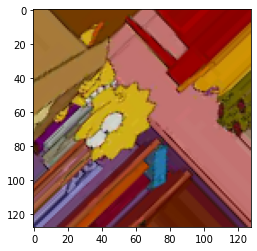

In [90]:
# imagen muestra del daset de entrenamiento de 128 x 128 en RGB generada por ImageDataGenerator 
plt.imshow(x_test[0]) 
plt.show()

In [91]:
#El vector one hot de la imagen muestra
print(y_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


2) Diseñar una arquitectura de AE para reconstruir imágenes de los diferentes ciudadanos de Springfield. El AE puede hacerse con una capaz completamente conectadas o con capas convolucionales y  de MaxPooling, el diseño es libre.

##Arquitectura

Se diseño una AE asimétrica con 3 capas convolucionales y 4 deconvolucionales con maxpooling

In [260]:
class DNN_model(tf.Module):
  def __init__(self,
               n_classes=49):
    
    self.C1LW = tf.Variable(0.001*np.random.rand(5,5,3,16),name="hl1weigths",dtype="float32") # parametros de la capa 1 con 16 caracteristicas con un grid de 5 x 5
    self.C1LB = tf.Variable(0.001*np.random.rand(16),name="hl1bias",dtype="float32")

    self.C2LW = tf.Variable(0.001*np.random.rand(3,3,16,8),name="h2weigths",dtype="float32") #  parametros de la capa 2 con 8 caracteristicas con un grid de 1 x 3
    self.C2LB = tf.Variable(0.001*np.random.rand(8),name="hl2bias",dtype="float32")
   
    self.C3LW = tf.Variable(0.001*np.random.rand(3,3,8,4),name="hl3weigths",dtype="float32") #  parametros de la capa 3 con 4 caracteristicas con un grid de 3 x 1
    self.C3LB = tf.Variable(0.001*np.random.rand(4),name="hl3bias",dtype="float32")                                         

    #*************************************************************************************************  Recontrucción de la imagen 

    self.D1LW = tf.Variable(0.001*np.random.rand(2,2,4,4),name="hl5weigths",dtype="float32") #  parametros de la capa 1 con 4 caracteristicas con un grid de 2 x 2 
    self.D1LB = tf.Variable(0.001*np.random.rand(4),name="hl5bias",dtype="float32")

    self.D2LW = tf.Variable(0.001*np.random.rand(3,1,4,4),name="hl6weigths",dtype="float32") #  parametros de la capa 2 con 4 caracteristicas con un grid de 3 x 1
    self.D2LB = tf.Variable(0.001*np.random.rand(4),name="hl6bias",dtype="float32")

    self.D3LW = tf.Variable(0.001*np.random.rand(1,3,4,4),name="hl7weigths",dtype="float32") #  parametros de la capa 3 con 4 caracteristicas con un grid de 1 x 3
    self.D3LB = tf.Variable(0.001*np.random.rand(4),name="hl7bias",dtype="float32")

    self.D4LW = tf.Variable(0.001*np.random.rand(3,3,3,4),name="hl8weigths",dtype="float32") #  parametros de la capa 4 con 3 caracteristicas con un grid de 5 x 5
    self.D4LB = tf.Variable(0.001*np.random.rand(3),name="hl9bias",dtype="float32")

          
  def __call__(self,x,Batch): 

      # Declarando la arquitectura
      x  = tf.cast(x, tf.float32)
      img = tf.reshape(x, shape=[-1, 128, 128, 3])

      #Capas convulucionales
      C1 = tf.nn.conv2d(img,self.C1LW, strides=[1,1,1,1], padding='SAME')             # Convolución de la imagen con los paramtros de la capa 1
      C1 = tf.add(C1, self.C1LB)                                                      # Al resultado de la convolución se le suma el paramtro de C1LB, número de caracteristicas
      C1 = tf.nn.relu(C1)                                                             # Al sumarlos se evalia con un función relu  
      C1 = tf.nn.max_pool(C1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")     # Se aplica el maxpooling con un strides de 2 reduciendo la imagen a la mitad
      #imagen resultante 64x64x16
      C2 = tf.nn.conv2d(C1,self.C2LW, strides=[1,1,1,1], padding='SAME')  
      C2 = tf.add(C2, self.C2LB)
      C2 = tf.nn.relu(C2)
      C2 = tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")      
      #imagen resultante 32x32x8
      C3 = tf.nn.conv2d(C2,self.C3LW, strides=[1,1,1,1], padding='SAME')  
      C3 = tf.add(C3, self.C3LB)
      C3 = tf.nn.relu(C3)
      C3 = tf.nn.max_pool(C3, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
      #imagen resultante 16x16x4

      #Capas de deconvolución
      D1 = tf.nn.conv2d_transpose(C3,self.D1LW, tf.constant([Batch,16,16,4]),strides=[1,1,1,1],padding='SAME')  # TF dispone de la conv2d_transpose, tf.constant es la forma en la que debe salir la imagen resultante
      D1 = tf.add(D1, self.D1LB)                                                                                # Batch, nos ayuda a indicarle a las capas con2d_transpose cuántas imágenes debe reconstruir o generar 
      D1 = tf.nn.relu(D1)                                                                                       # Al sumarlos se evalia con un función relu
      D1 = tf.keras.layers.UpSampling2D((2,2))(D1)                                                              # Se apliva upsampling2D de 2 x 2 para recontriur la imagen  
  
      D2 = tf.nn.conv2d_transpose(D1,self.D2LW, tf.constant([Batch,32,32,4]),strides=[1,1,1,1],padding='SAME')  
      D2 = tf.add(D2, self.D2LB)
      D2 = tf.nn.relu(D2)
      D2 = tf.keras.layers.UpSampling2D((2,2))(D2)

      D3 = tf.nn.conv2d_transpose(D2,self.D3LW, tf.constant([Batch,64,64,4]),strides=[1,1,1,1],padding='SAME')  
      D3 = tf.add(D3, self.D3LB)
      D3 = tf.nn.relu(D3)
      D3 = tf.keras.layers.UpSampling2D((2,2))(D3)

      D4 = tf.nn.conv2d_transpose(D3,self.D4LW, tf.constant([Batch,128,128,3]),strides=[1,1,1,1],padding='SAME')  
      D4 = tf.add(D4, self.D4LB)
      D4 = tf.nn.relu(D4)
      D4 = tf.keras.layers.UpSampling2D((1,1))(D4)
      
      return D4


  

In [261]:
DNN = DNN_model() #instancia del modelo 

In [262]:
optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001) #optimizador adam

In [263]:
# se definen las metricas de perdida, no es necesario usar accuracy
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [264]:
@tf.function
def train_step(model,tdata, labels):
  with tf.GradientTape() as tape:
    #Necesitamos enviarle el tamaño del batch a la red
    predictions = model(tdata,len(tdata))
    
    #calculo de una funcion de error 
    # GradientTape se hace la conversión de la entrada,
    # Primero,el tipo de dato que nos va a regresar la red
    x = tf.cast(labels, tf.float32)
    # y luego, ajustamos sus dimensiones para que sean iguales a las de la salida de la red
    # en formato NHWC
    img = tf.reshape(x, shape=[-1, 128, 128, 3])
    #Calculamos el error, el que usamos en el AE es un error de regresión, por eso usamos el error cuadratico medio
    loss_funct = tf.keras.losses.huber #*
    loss = tf.reduce_mean(loss_funct(img, predictions))
   
  gradients = tape.gradient(loss, model.trainable_variables)
  capped_grads_and_vars = [(grad,model.trainable_variables[index]) for index, grad in enumerate(gradients)]
  optimizador.apply_gradients(capped_grads_and_vars)
  train_loss(loss)

En estadística , la pérdida de Huber es una función de pérdida utilizada en la regresión robusta , que es menos sensible a valores atípicos en los datos que la pérdida de error al cuadrado .

In [265]:
@tf.function
def test_step(model,tdata, labels):
  predictions = model(tdata,len(tdata))
  x = tf.cast(labels, tf.float32)
  img = tf.reshape(x, shape=[-1, 128, 128, 3])
  loss_funct = tf.keras.losses.huber
  t_loss = tf.reduce_mean(loss_funct(img, predictions))

  test_loss(t_loss)

In [266]:
def prueba():
  (x_train,y_train) = dataset_train.next()        # Se creo una función para cuando sea llamada se ejecute la función .next() y envie los diferentes dataset creados en el pre procesamiento
  (x_test,y_test) = dataset_test.next()
  return x_train

In [267]:
def fitting(model,train_x,train_y,test_x,test_y,EPOCHS,N_batch,batch_size,load=False):
  if load:
    print("cargando modelo...")
    checkpoint= tf.train.Checkpoint(model)
    checkpoint.read("/content/drive/My Drive/Colab Notebooks/MNIST_AECNN_ckpt")
    #Cargamos un oprtimizador, como siempre, usaremos el de cajón con un learning rate comun
    optimizador = tf.compat.v1.train.AdamOptimizer(learning_rate=0.00025)
    print("modelo cargado :D")
  i=[]
  train_x = prueba()
  for epoch in range(EPOCHS):
    train_step(model,train_x,train_x)
    test_step(model,test_x,test_y)

    if epoch % 50==0 or epoch==EPOCHS-1:  
      template = 'Epoch {}, Perdida: {},  Perdida de prueba: {}'
      print(template.format(epoch,train_loss.result(),test_loss.result()))
      print("Prueba de desempeño...")
      print("Imagen objetivo")
      img1 = train_x[0]
      plt.imshow(img1)
      plt.show()
      print("Imagen reconstruida...")
      img2 = model(train_x[0], 1)
      plt.imshow(np.reshape(img2[0],(128,128,3)),cmap='viridis')
      plt.show()
    if epoch==EPOCHS-1:
      i.append(model(train_x))

    train_loss.reset_states()
    
    test_loss.reset_states()
  return i    

Epoch 0, Perdida: 0.00841708667576313,  Perdida de prueba: 0.018913500010967255
Prueba de desempeño...
Imagen objetivo


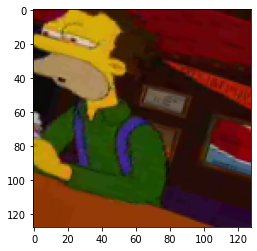

Imagen reconstruida...


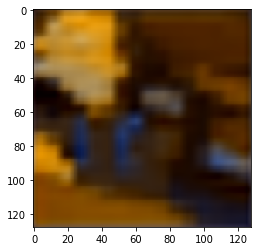

Epoch 50, Perdida: 0.00775436544790864,  Perdida de prueba: 0.018862992525100708
Prueba de desempeño...
Imagen objetivo


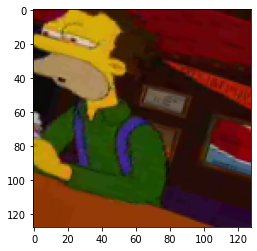

Imagen reconstruida...


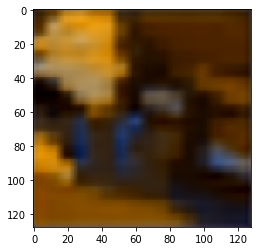

Epoch 100, Perdida: 0.007745744194835424,  Perdida de prueba: 0.018846973776817322
Prueba de desempeño...
Imagen objetivo


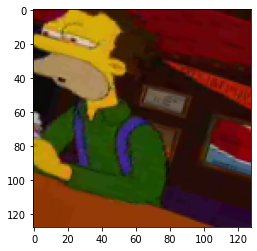

Imagen reconstruida...


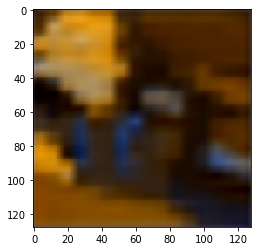

Epoch 150, Perdida: 0.007736736908555031,  Perdida de prueba: 0.0188407264649868
Prueba de desempeño...
Imagen objetivo


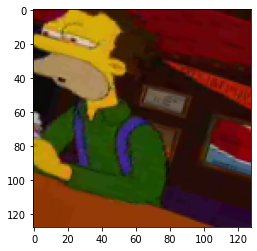

Imagen reconstruida...


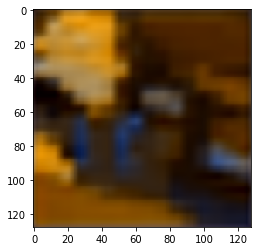

Epoch 200, Perdida: 0.00772789167240262,  Perdida de prueba: 0.018817875534296036
Prueba de desempeño...
Imagen objetivo


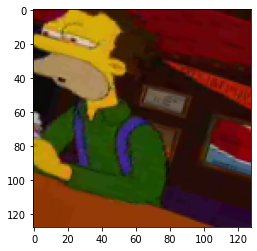

Imagen reconstruida...


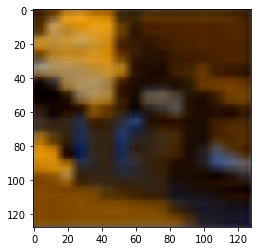

Epoch 250, Perdida: 0.007732555735856295,  Perdida de prueba: 0.018809152767062187
Prueba de desempeño...
Imagen objetivo


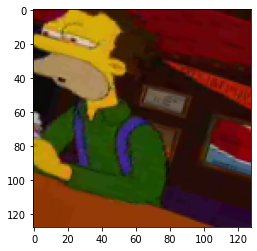

Imagen reconstruida...


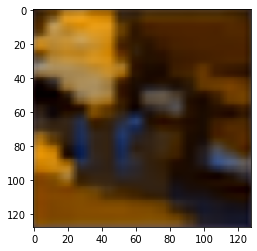

Epoch 300, Perdida: 0.007713643833994865,  Perdida de prueba: 0.018791547045111656
Prueba de desempeño...
Imagen objetivo


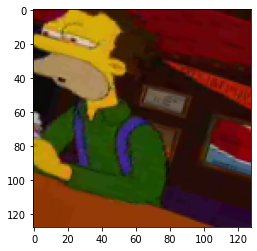

Imagen reconstruida...


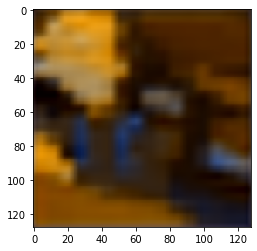

Epoch 350, Perdida: 0.007717785891145468,  Perdida de prueba: 0.0187788438051939
Prueba de desempeño...
Imagen objetivo


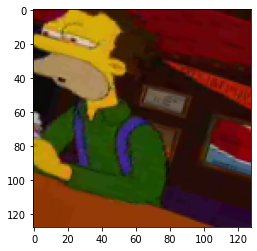

Imagen reconstruida...


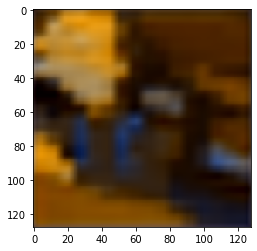

Epoch 400, Perdida: 0.007704033050686121,  Perdida de prueba: 0.01875566504895687
Prueba de desempeño...
Imagen objetivo


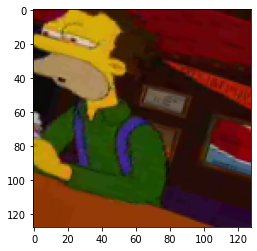

Imagen reconstruida...


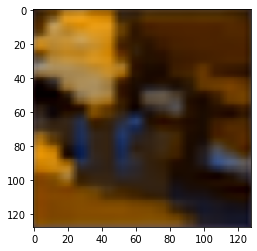

Epoch 450, Perdida: 0.007728039287030697,  Perdida de prueba: 0.01880797930061817
Prueba de desempeño...
Imagen objetivo


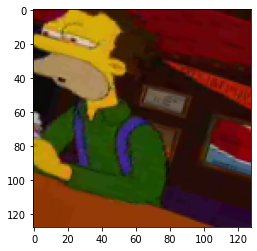

Imagen reconstruida...


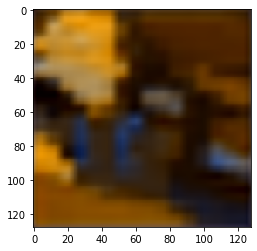

Epoch 500, Perdida: 0.007696201093494892,  Perdida de prueba: 0.018760500475764275
Prueba de desempeño...
Imagen objetivo


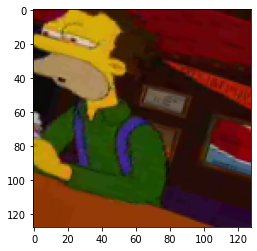

Imagen reconstruida...


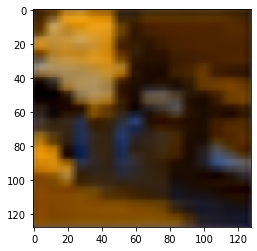

Epoch 550, Perdida: 0.007683855015784502,  Perdida de prueba: 0.018710201606154442
Prueba de desempeño...
Imagen objetivo


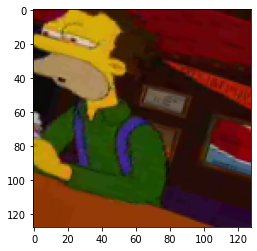

Imagen reconstruida...


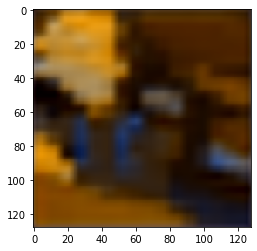

Epoch 600, Perdida: 0.007704172283411026,  Perdida de prueba: 0.018799057230353355
Prueba de desempeño...
Imagen objetivo


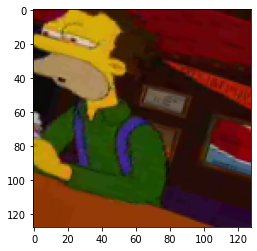

Imagen reconstruida...


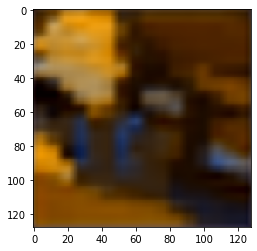

Epoch 650, Perdida: 0.007671360857784748,  Perdida de prueba: 0.018681278452277184
Prueba de desempeño...
Imagen objetivo


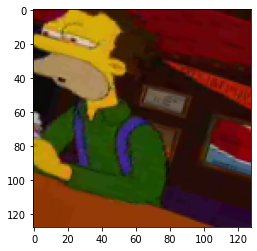

Imagen reconstruida...


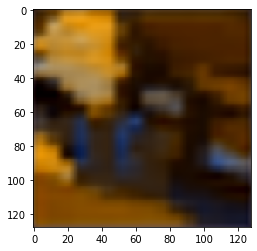

Epoch 700, Perdida: 0.007664613891392946,  Perdida de prueba: 0.018706249073147774
Prueba de desempeño...
Imagen objetivo


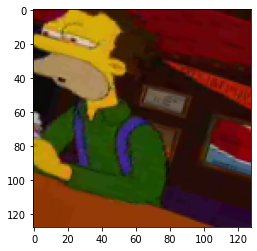

Imagen reconstruida...


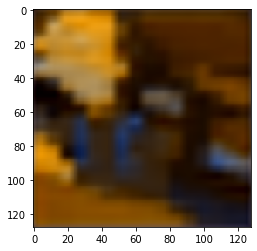

Epoch 750, Perdida: 0.007663572672754526,  Perdida de prueba: 0.01867186836898327
Prueba de desempeño...
Imagen objetivo


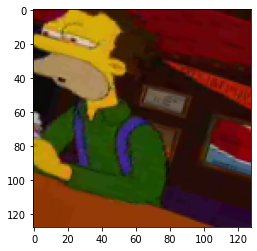

Imagen reconstruida...


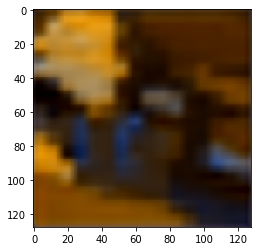

Epoch 799, Perdida: 0.007643516641110182,  Perdida de prueba: 0.018638087436556816
Prueba de desempeño...
Imagen objetivo


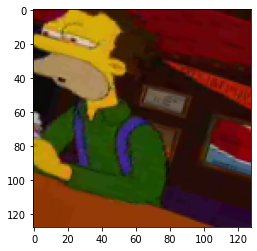

Imagen reconstruida...


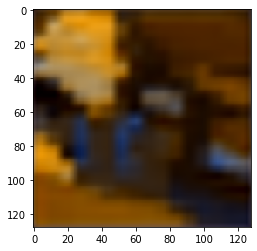

In [ ]:
fitting(DNN,x_train,x_train,x_test,x_test,800,500,100,False)

Conclusiones:

La herramienta ImageDataGenerator de keras es una buena opción para el aumento de datos pero es necesario tener en cuenta que el tensor de que va entrar en la AE es de dimenciones (batch_size, caracteristicas, ancho, alto) en las priemas pruebas se creaban tensores de 500 x 36 x 200 x 200 por lo que se desbordaba la memoria de la GPU

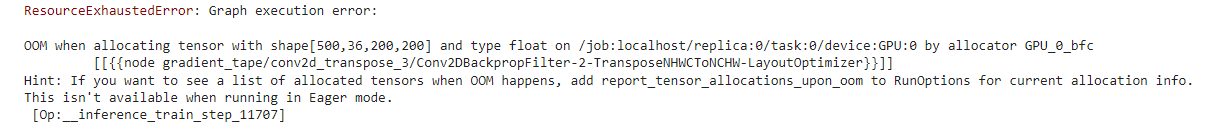

Por cuesciones de hardware se implemento con imagenes de 128 x 128 y 300 muestras por lote, creadas por ImagenDataGenerator

El número de caracteristicas fue un factor muy importante en este trabajo ya que si las caracteristicas eran demaciadas la red no podia recontruir la imagen, además de que el tensor aumantaba su tamaño, es necesario tomar a la hora de entrenar los modelos

##Resultados



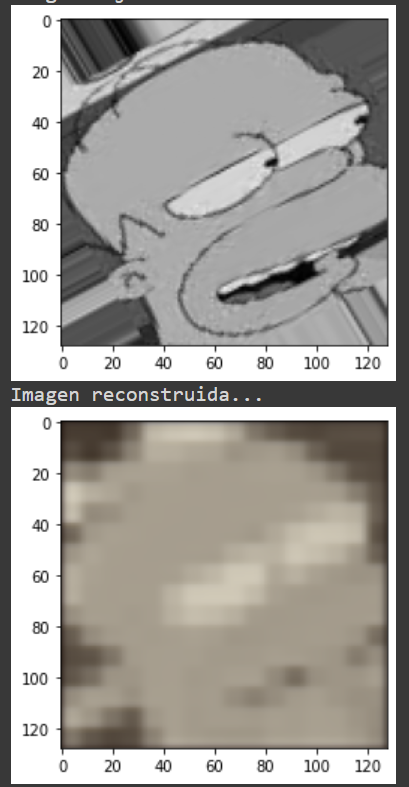

Referencias:

Notas y código de la clases Redes Neuronales Avanzadas (B22)

https://www.tensorflow.org/

https://keras.io/

Descripcion de los colores de una imagen mediante tecnicas de Deep learning (oscar prades palacios)


Diseño de una arquitectura 
de Red Neuronal 
Convolucional para la 
clasificación de objetos 